In [2]:
import os, glob, time
import cv2
import faiss
import matplotlib.pyplot as plt
import numpy as np

"""
Our image codebook library contains a bunch of images. We downsize them to the VECTORIZATION_TILE_SIZE. 

Next, we divide our target image into segments of MOSIAC_TILE_SIZE. For each of these, we resize
to VECTORIZATION_TILE_SIZE and vectorize. 

We finally retrieve the closest codebook image and replace the MOSIAC_TILE_SIZE section of the target
image with a MOSIAC_TILE_SIZE sized rendering of the codebook image. 

Constraints:
1) VECTORIZATION_TILE_SIZE and MOSIAC_TILE_SIZE should be the same aspect ratio. 

Storage:
1) Codebook images in MOSIAC_TILE_SIZE size. 
2) Function for taking: VECTORIZATION_TILE_SIZE -> index into 1) image list (above)
"""
MOSIAC_TILE_SIZE = (64, 64)
VECTORIZATION_TILE_SIZE = (64, 64)

p = 'emosiac/tests/input/kiss.png'
# p = 'images/all_emojis/1f1fa-1f1f8.png'
bgr_img = cv2.imread(p, cv2.IMREAD_UNCHANGED)[:,:,:3]

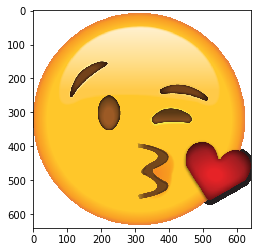

In [105]:
plt.imshow(bgr_img[:, :, [2, 1, 0]])

In [124]:
# https://github.com/facebookresearch/faiss/blob/223d4e32d8dcc08342da6ca686f09edc00daa37d/benchs/bench_hnsw.py#L65

# example matrix
popular_emoji_paths = glob.glob('images/popular_emojis/*.png')

def resize_square_image(img, factor, interpolation=cv2.INTER_AREA):
    return cv2.resize(img, None, fx=factor, fy=factor, interpolation=interpolation)

def make_image_with_noise_background(img_with_alpha):
    """
    Returns image with background filled with random noise
    dtype of return image is a float64
    """
    # https://docs.opencv.org/3.4.2/d0/d86/tutorial_py_image_arithmetics.html
    img = np.copy(img_with_alpha)

    # load image and isolate mask
    bgr_img = img[:, :, :3]
    alpha = img[:, :, 3]
    _, img_mask = cv2.threshold(alpha, 10, 255, cv2.THRESH_BINARY)
    not_img_mask = cv2.bitwise_not(img_mask)

    # create a noise image
    noise_shape = (bgr_img.shape[0], bgr_img.shape[1], 3)
    noise[:, :, :3] = np.random.random(noise_shape).astype(np.float32)

    # apply mask
    noise_bg = cv2.bitwise_and(noise, noise, mask=not_img_mask)
    img_fg = cv2.bitwise_and(bgr_img, bgr_img, mask=img_mask) / 255.
    img_with_noise = cv2.add(noise_bg, img_fg).astype(np.float32)
    return img_with_noise

def to_vector(img, factor=0.1):
    """
    (640 x 640 x 3) => (64 x 64 x 3) => (64*64*3, 1)
    """
    resized = resize_square_image(img, factor=factor)
    return resized.reshape((-1,)) / 255.0

def index_images(paths, vectorization_downsize_factor=0.1, resize_downsize_factor=1):
    """
    @return: valid_image_paths
    @return: valid_images
    @return: index
    """
    dimensions = int(640 * 640 * 3 * vectorization_downsize_factor ** 2)
    index = faiss.IndexFlatL2(dimensions)  # 100% accurate, in-memory. OK for now.
    
    vectors = []
    valid_image_paths = []
    images = []
    
    for p in paths:
        # load image, validate
        img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
        if img.shape != (640, 640, 4):
            failed.append(p)
            continue
        
        # add random noise & downsize if needed
        img_with_noise = make_image_with_noise_background(img)[:, :, [2, 1, 0]]
        resized = resize_square_image(img_with_noise, factor=resize_downsize_factor)
        images.append(resized)
        
        # vectorize
        v = to_vector(img_with_noise, factor=vectorization_downsize_factor)
        vectors.append(v)
        valid_image_paths.append(p)
        
    # now combine into matrix
    n = len(vectors)
    matrix = np.zeros((n, dimensions), dtype=np.float32)
    for i, v in enumerate(vectors):
        matrix[i, :] = v
        
    # display the matrix as an image
    #plt.imshow(matrix)
    #plt.savefig('vectors.png', dpi=1024)
        
    # index our images
    index.add(matrix)
    
    # return needed data
    return valid_image_paths, images, index

# do the indexing
valid_emoji_paths, noise_imgs, index = \
    index_images(
        popular_emoji_paths, 
        vectorization_downsize_factor=0.1, 
        resize_downsize_factor=1)


(640, 640, 3)


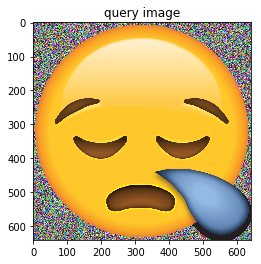

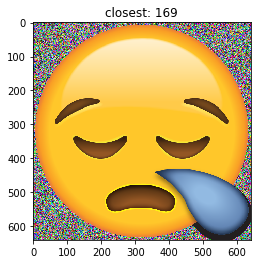

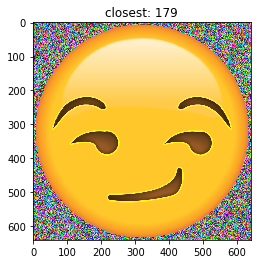

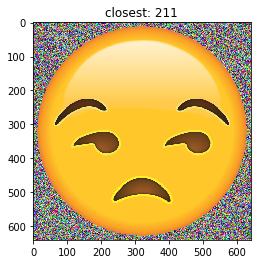

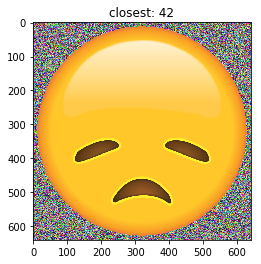

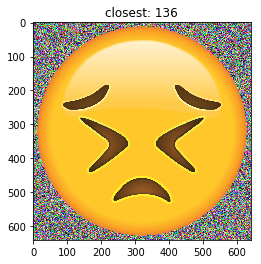

In [200]:
# p = valid_emoji_paths[23]  # emosiac/tests/input/kiss.png'
# img = cv2.imread(p, cv2.IMREAD_UNCHANGED)[:,:,:3]

def query_k(index, img, k=2, downsize_factor=1, verbose=0):
    try:
        # vectorize query image
        v = to_vector(img, factor=downsize_factor).astype(np.float32)

        # perform the query
        D, I = index.search(v.reshape((1, -1)), k=k)     # actual search
        return D, I
    except Exception:
        import ipdb; ipdb.set_trace()
        return None, None

# grab any image to use as a test & do query
img = noise_imgs[169]
D, I = query_k(index, img, downsize_factor=0.1, k=5)
print(img.shape)

def showimg(img, title=None):
    rbg_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rbg_img)
    if title: 
        plt.title(title)
    plt.show()

showimg(img[:, :, [2, 1, 0]], title='query image')

for idx in list(I.flatten()):
    pimg = noise_imgs[idx]
    showimg(pimg[:, :, [2, 1, 0]], title='closest: %d' % idx)

float64
float64
float64
(640, 640, 3)


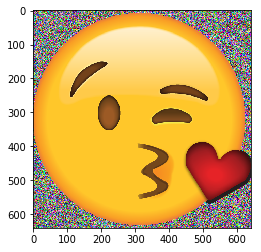

In [103]:
# load image and isolate mask
img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
bgr_img = img[:, :, :3]
alpha = img[:, :, 3]
_, img_mask = cv2.threshold(alpha, 10, 255, cv2.THRESH_BINARY)
not_img_mask = cv2.bitwise_not(img_mask)

# create some random noise
b_noise = np.random.random(alpha.shape).astype(np.float32)
g_noise = np.random.random(alpha.shape).astype(np.float32)
r_noise = np.random.random(alpha.shape).astype(np.float32)

# test that noise looks like we think it should
noise = np.zeros((img.shape[0], img.shape[1], 3))
noise[:, :, 0] = b_noise
noise[:, :, 1] = g_noise
noise[:, :, 2] = r_noise
plt.imshow(noise)

# apply mask
noise_bg = cv2.bitwise_and(noise, noise, mask=not_img_mask)
plt.imshow(noise_bg)
print(noise_bg.dtype)

img_fg = cv2.bitwise_and(bgr_img, bgr_img, mask=img_mask) / 255.0
plt.imshow(img_fg)
print(img_fg.dtype)

final = cv2.add(noise_bg, img_fg).astype(np.float32)
plt.imshow(final[:, :, [2, 1, 0]]) # BGR -> RGB
print(img_fg.dtype)

for_writing = (final * 255).astype(np.uint8)  # must save as uint8
cv2.imwrite('noise-with-image.jpg', for_writing)

print(final.shape)


(1520, 1919, 3)


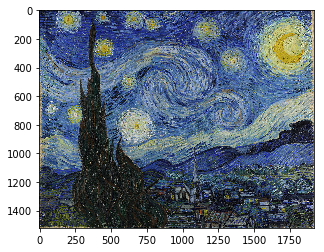

In [304]:
# load background image
bg = cv2.imread('images/backgrounds/starry-night.jpg')
print(bg.shape)
plt.imshow(bg[:, :, [2,1,0]])

In [252]:
def divide_image(img, pixels):
    """
    img: numpy ndarray (3D, where 3rd channel is channel)
    pixels: int, number of pixels for squares to divide into
    """
    h, w, _ = img.shape

    num_height_boxes = int(h / pixels)
    num_width_boxes = int(w / pixels)

    height_offset = int((h % pixels) / 2)
    width_offset = int((w % pixels) / 2)

    x_starts = [x*pixels + width_offset  for x in range(num_width_boxes) ]
    y_starts = [y*pixels + height_offset for y in range(num_height_boxes)]

    box_starts = []
    for i, x in enumerate(x_starts):
        for j, y in enumerate(y_starts):
            box_starts.append((x, y))

    return box_starts

box_starts = divide_image(bg, pixels=64)

In [161]:
1

1

Took 3.5156 seconds


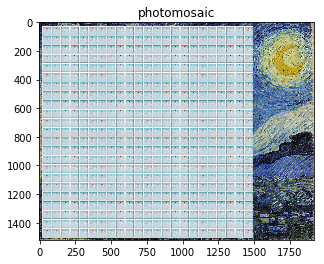

<Figure size 432x288 with 0 Axes>

In [305]:
starttime = time.time()

for i, (x, y) in enumerate(box_starts):
    bg_patch = bg[x:x+pixels, y:y+pixels, :]
    if bg_patch.shape != (64, 64, 3):
        continue
        
    # query for closest image from codebook
    D, I = query_k(index, bg_patch, k=1, downsize_factor=1)
    plt.imshow(bg_patch[:, :, [2,1,0]])
    idx = I[0][0]

    # show our target patch
#     plt.imshow(bg_patch[:, :, [2,1,0]])
#     plt.title('reference patch')
#     plt.show()
    
    # get replacement
    replacement = resize_square_image(noise_imgs[idx], factor=0.1)
#     plt.imshow(replacement[:, :, :])
#     plt.title('replacement')
#     plt.show()
    bg[x:x+pixels, y:y+pixels, :] = replacement[:, :, [2,1,0]] * 255.0

elapsed = time.time() - starttime
print("Took %.4f seconds" % elapsed)

# show the mosiac so far
plt.clf()
plt.title('photomosaic')
plt.imshow(bg[:, :, [2,1,0]])
plt.savefig('bleh.png', dpi=1024)


(64, 64, 3)


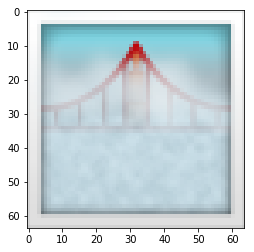

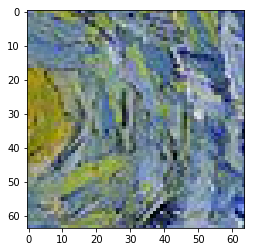

In [276]:
bg[x:x+pixels, y:y+pixels, :].shape == replacement.shape
print(replacement.shape)
plt.imshow(replacement)
plt.show()

plt.imshow(bg[x:x+pixels, y:y+pixels, [2,1,0]])
plt.show()

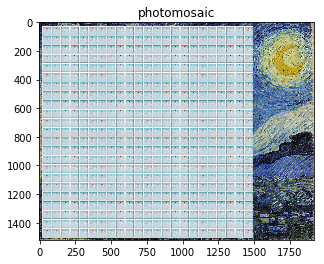

In [306]:
plt.title('photomosaic')
plt.imshow(bg[:, :, [2,1,0]])
plt.savefig('bleh.png', dpi=1024)

In [3]:
from emosiac.image import Image
from multiprocessing.pool import ThreadPool
import random
        
paths = glob.glob('images/pics/*.jpg')
random.shuffle(paths)
images = []
colors = ('b', 'g', 'r')
nchannels = 3

# settings for dominant color calculations
num_dominant_colors = 3  # for kmeans model
dominant_color_width = 300  # how wide to plot
dominant_color_subsample = 0.05  # [0, 1] and lower == faster

In [11]:
# sizing for mosaic tiles
scale = 8
height_aspect, width_aspect = 4, 3
height, width = height_aspect * scale, width_aspect * scale
aspect_ratio = height / float(width)

# sizing for vectorization dimensionality
vectorization_scaling_factor = 1
vectorization_dimensionality = height * width * vectorization_scaling_factor * nchannels

def to_vector(img, h, w, c):
    """
    @param: img (numpy arr), image to vectorize
    @param: h (int), desired height to resize to
    @param: w (int), desired width to resize to
    @param: number of channels on this image
    
    @return: np.float32 array of shape: (-1, h * w * c)
    """
    img_h, img_w, _ = img.shape
    resized = cv2.resize(
        img, None,
        fx=h / float(img_h),
        fy=w / float(img_w),
        interpolation=cv2.INTER_AREA)
    return resized.reshape(-1, h * w * c).astype(np.float32)

def load_and_vectorize_image(args):
    """
    @args: (path, h, w, c, aspect_ratio)
        path (String) to load image from
        h (int) height
        w (int) width
        c (int) number of channels
        aspect_ratio (float) that is allowed (height / width)
        
    @return: tuple (Image object, numpy arr of vectorized image), but
        returns (None, None) if the aspect ratio of the image doesn't match 
        the argument aspect_ratio given
    """
    path, h, w, c, aspect_ratio = args
    image = Image(path)
    img = image.compute_statistics()
    if image.aspect_ratio == aspect_ratio:
        v = to_vector(img, h, w, c)
        return image, v
    else:
        return None, None

# index our images
index = faiss.IndexFlatL2(vectorization_dimensionality)  # just a flat index for now, nothing crazy

# create our pool and go!
starttime = time.time()
path_jobs = [(p, height, width, nchannels, aspect_ratio) for p in paths]  #[:200]

pool = ThreadPool(5)
results = pool.map(load_and_vectorize_image, path_jobs)
pool.close()

# how fast did we go?
elapsed = time.time() - starttime
print("took %.4f seconds (%.4f per image)" % (elapsed, elapsed / len(path_jobs)))

# get the results, store in ordered (indexed) list
images = []
vectors = []
for image, vector in results:
    if image is not None and vector is not None:
        vectors.append(vector)
        images.append(image)
        
# create matrix and index
matrix = np.array(vectors).reshape(-1, vectorization_dimensionality)
index.add(matrix)

# resize & cache
tile_images = []
for image in images:
    img = image.load_image()
    img_h, img_w, _ = img.shape
    tile = cv2.resize(
        img,
        None,
        fx=height / float(img_h),
        fy=width / float(img_w),
        interpolation=cv2.INTER_AREA)
    tile_images.append(tile)


took 89.5232 seconds (0.0930 per image)


We have 9216 tiles to assign
Timings: mean=0.00038, stddev=0.00032


TypeError: %d format: a number is required, not numpy.ndarray

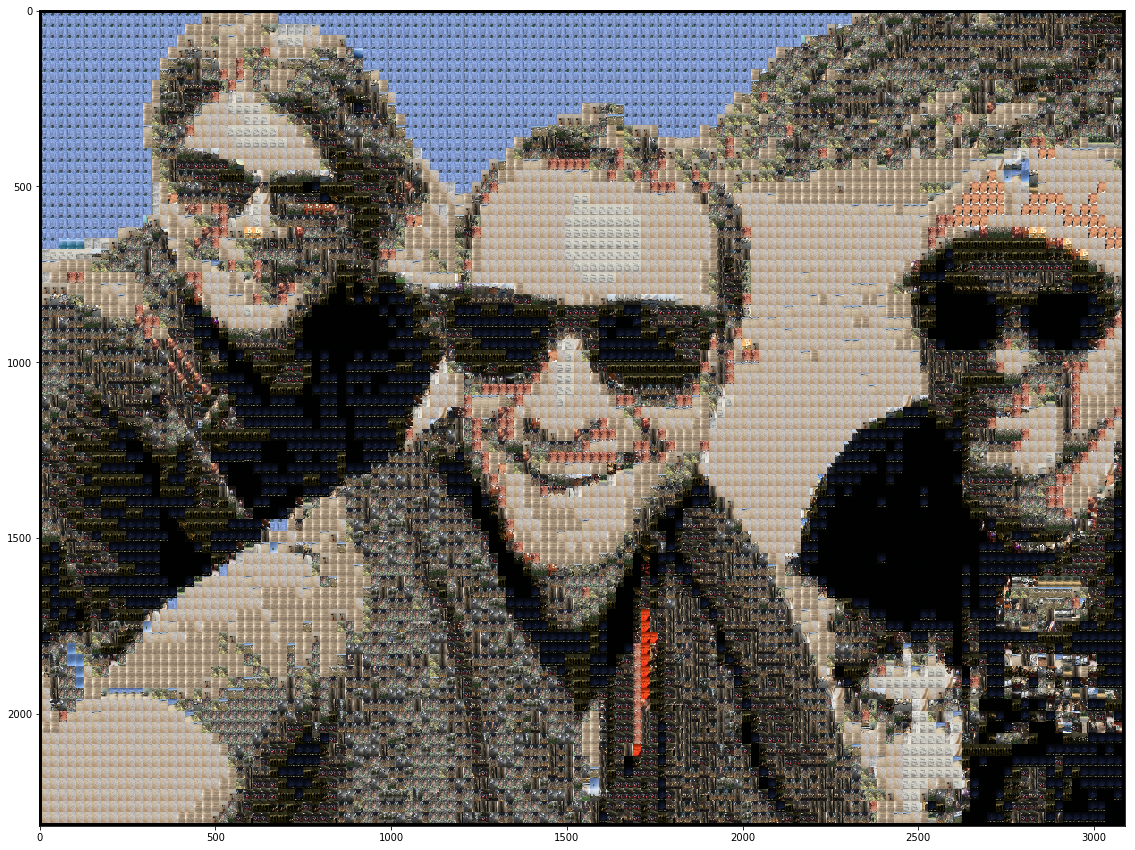

In [5]:
# recreate starry night
def divide_image_rectangularly(img, h_pixels, w_pixels):
    """
    img: numpy ndarray (3D, where 3rd channel is channel)
    h_pixels: int, number of pixels for height 
    w_pixels: int, number of pixels for width 
    """
    h, w, _ = img.shape

    num_height_boxes = int(h / h_pixels)
    num_width_boxes = int(w / w_pixels)

    height_offset = int((h % h_pixels) / 2)
    width_offset = int((w % w_pixels) / 2)

    x_starts = [x*h_pixels + height_offset  for x in range(num_height_boxes) ]
    y_starts = [y*w_pixels + width_offset   for y in range(num_width_boxes)]

    rect_starts = []
    for i, x in enumerate(x_starts):
        for j, y in enumerate(y_starts):
            rect_starts.append((x, y))

    return rect_starts

bg_path = 'images/pics/2018-04-01 12.00.27.jpg'
bg = cv2.imread(bg_path)
rect_starts = divide_image_rectangularly(bg, h_pixels=height, w_pixels=width)
mosaic = np.zeros(bg.shape)
timings = []
print("We have %d tiles to assign" % len(rect_starts))

for (j, (x, y)) in enumerate(rect_starts):
    starttime = time.time()
    
    # get our target region & vectorize it
    target = bg[x : x + height, y : y + width]
    target_h, target_w, _ = target.shape
    v = to_vector(target, height, width, nchannels)
    
    # find nearest codebook image
    _, I = index.search(v, k=1) 
    idx = I[0][0]
    closest_tile = tile_images[idx]
    
    # write into mosaic
    mosaic[x : x + height, y : y + width] = closest_tile
    
    # record the performance
    elapsed = time.time() - starttime
    timings.append(elapsed)
    
#     if j % 25 == 0:
#         print("working on tile %d..." % j)
#         print("closest image shape:", closest.shape)
#         print("target space:", bg[x : x + height, y : y + width].shape)
#         print("tile shape:", closest_tile.shape)
#         plt.imshow(closest_tile[:, :, [2,1,0]])
#         plt.show()
    
arr = np.array(timings)
print("Timings: mean=%.5f, stddev=%.5f" % (arr.mean(), arr.std()))
plt.figure(figsize = (64, 30))
plt.imshow(mosaic[:, :, [2,1,0]].astype(np.uint8), interpolation='nearest')
cv2.imwrite('mosaic-%s-scale-%d' % (os.path.basename(bg_path), scale), mosaic.astype(np.uint8))


In [69]:
starttime = time.time()

closest = images[I[0][0]].load_image()

elapsed = time.time() - starttime
print(elapsed)

0.398020982742


In [81]:
0.00203 * len(rect_starts) / 32

0.0569034375

Timings: mean=0.00038, stddev=0.00032, n=9216


True

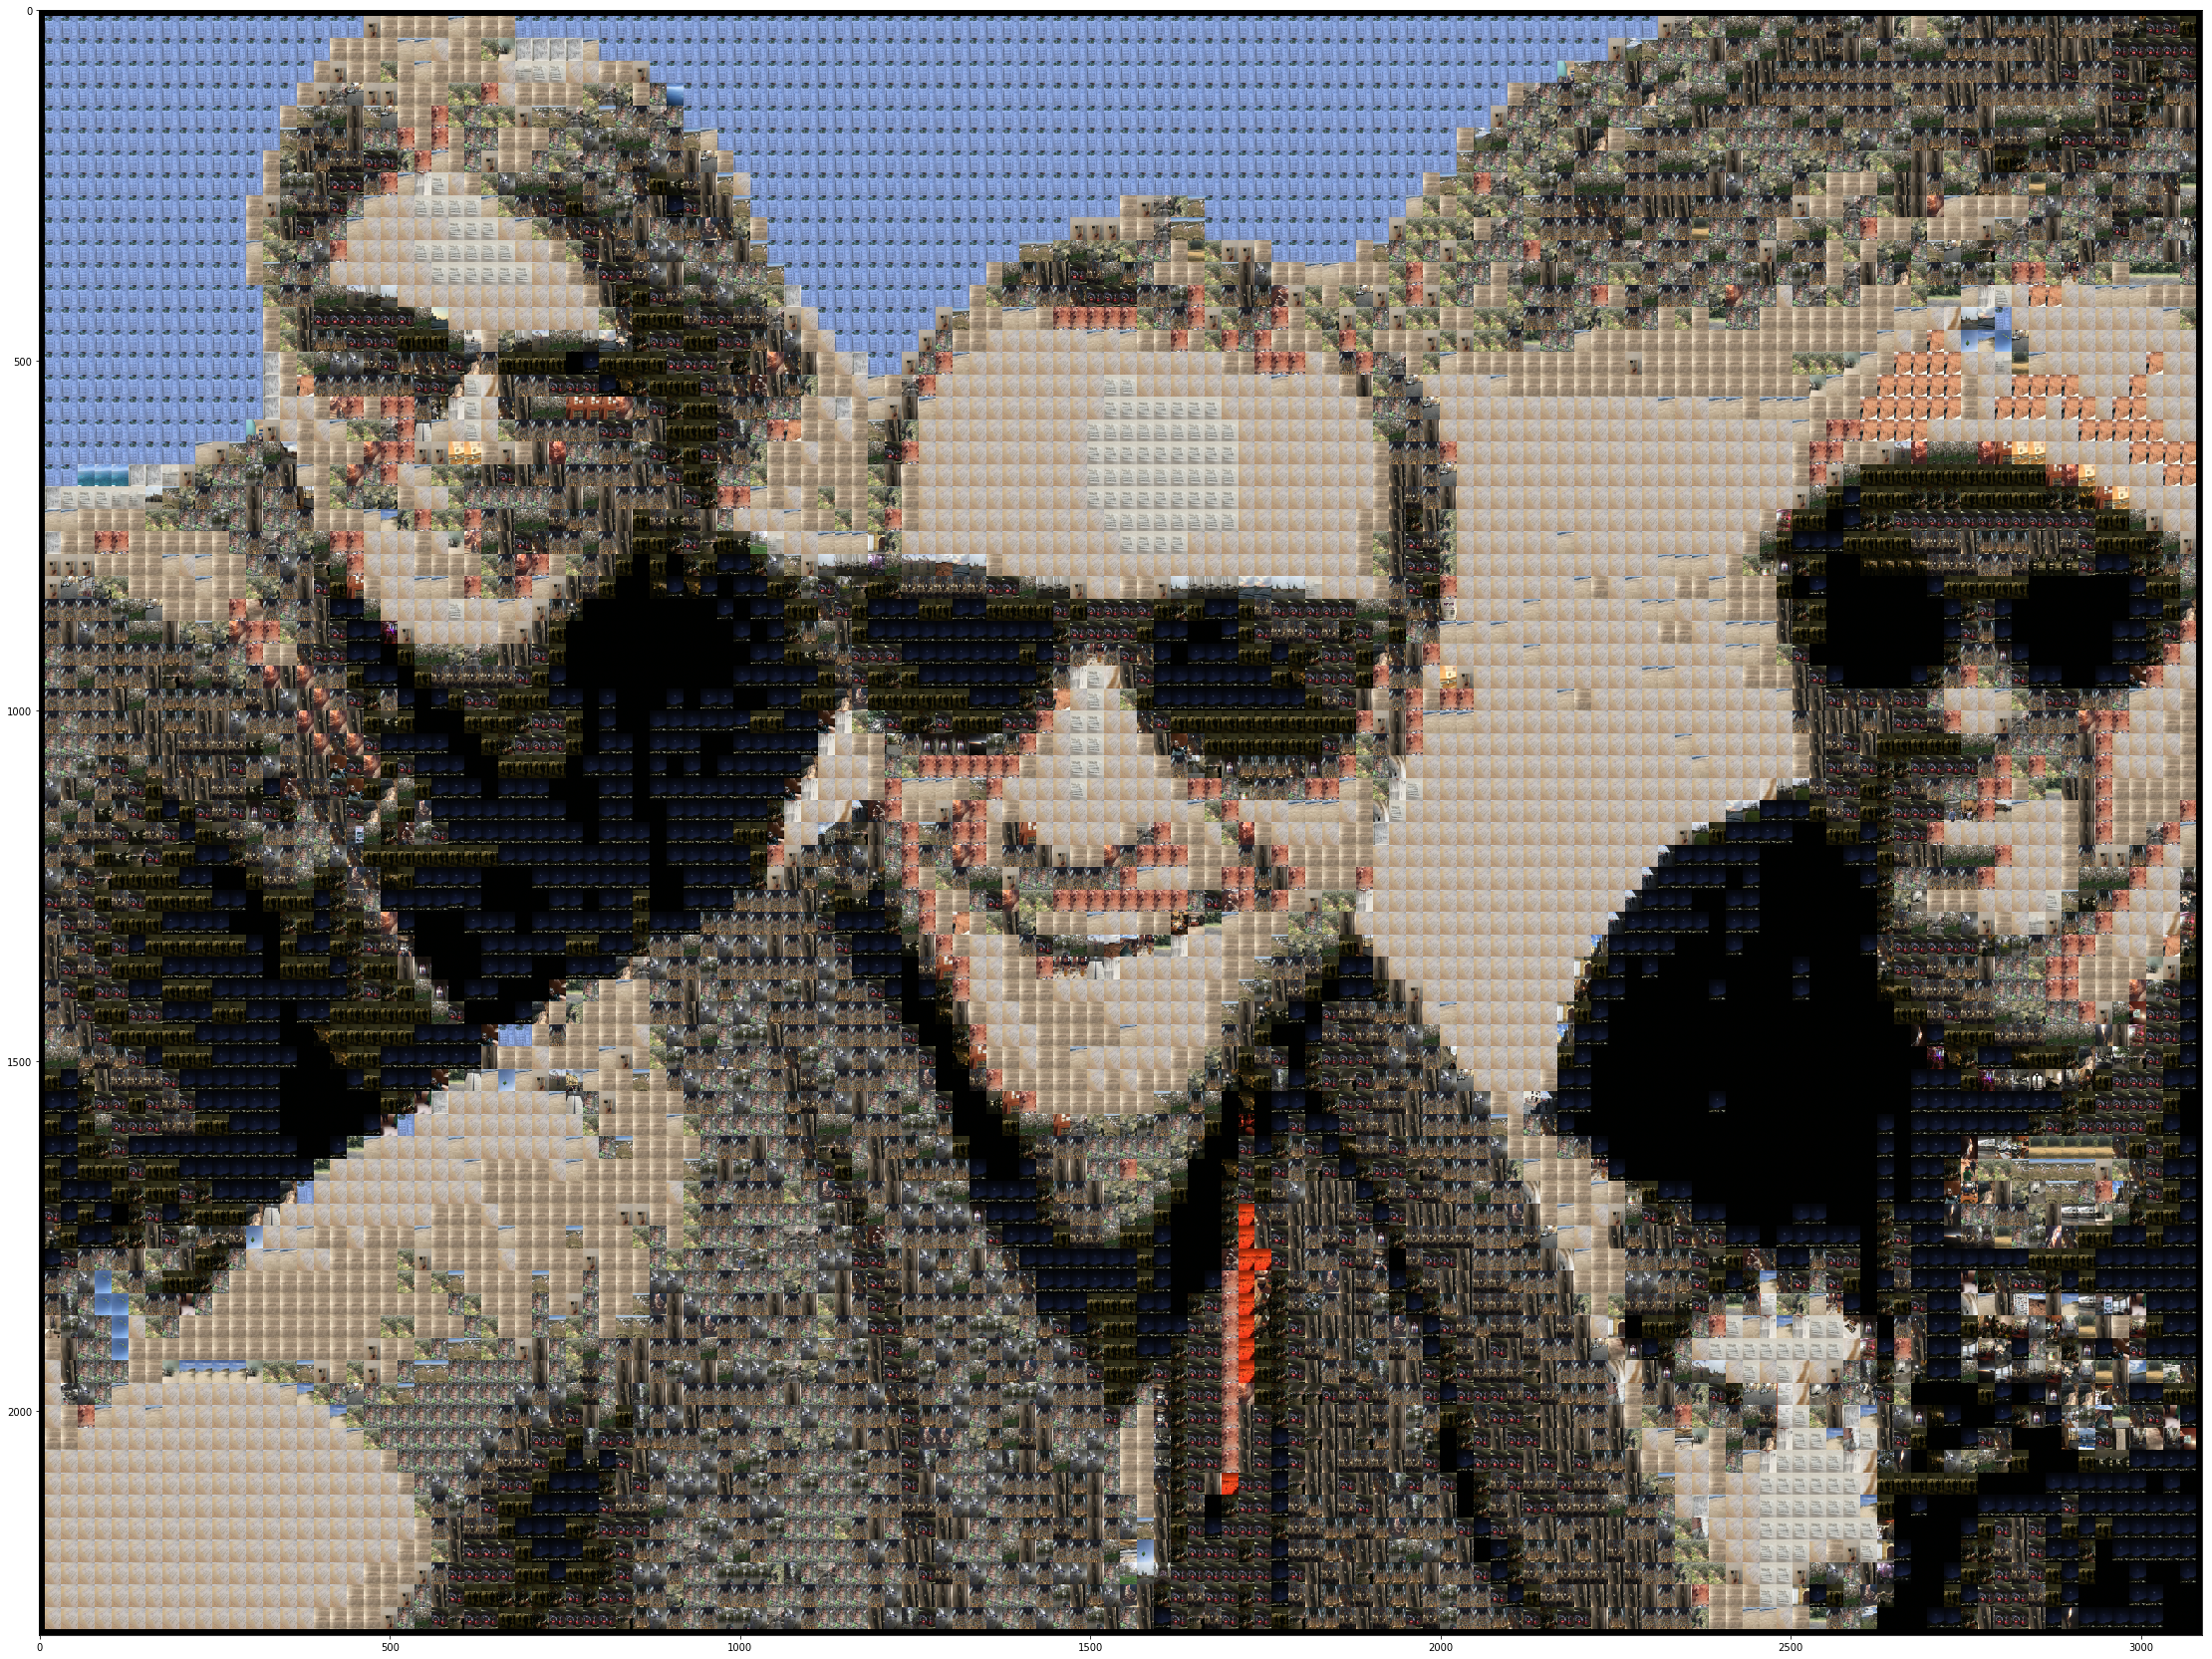

In [9]:
arr = np.array(timings)
print("Timings: mean=%.5f, stddev=%.5f, n=%d" % (arr.mean(), arr.std(), len(timings)))
plt.figure(figsize = (64, 30))
plt.imshow(mosaic[:, :, [2,1,0]].astype(np.uint8), interpolation='nearest')
cv2.imwrite('mosaic-%s-scale-%d.jpg' % (os.path.basename(bg_path), scale), mosaic.astype(np.uint8))

In [145]:
run make_gif.py \
    --target "media/pics/2018-04-01 12.00.27.jpg" \
    --savepath "media/output/%s-from-%d-to-%d.gif" \
    --codebook-dir "media/pics/" \
    --min-scale 5 \
    --max-scale 7 \
    --fps 3 \
    --ascending 0 \
    --randomness 0.5

Indexing scale=5...
Indexing: 142 images, 8.9310 seconds (0.0629 per image)
Resizing images to (20, 15)...
Indexing scale=6...
Indexing: 142 images, 10.1697 seconds (0.0716 per image)
Resizing images to (24, 18)...
Indexing scale=7...
Indexing: 142 images, 8.9405 seconds (0.0630 per image)
Resizing images to (28, 21)...





[MoviePy] Building file media/output/2018-04-01 12.00.27.jpg-from-5-to-7.gif with imageio


 75%|███████▌  | 3/4 [00:04<00:01,  1.58s/it]
